# Fine-tune Mimi Encoder for TTS Embeddings

Fine-tune last N layers of Mimi encoder to replicate Kyutai's TTS embedding model.

**Approach:**
- Unfreeze last 2 encoder layers (not LoRA)
- Add David Browne's 4-layer adapter on top
- MSE + cosine similarity loss (0.1 weight)
- Validation with batch_size=1 to avoid padding artifacts

In [1]:
import torch
import torchaudio
import numpy as np
from pathlib import Path
from dataclasses import dataclass
from collections import defaultdict
from tqdm.auto import tqdm
from safetensors.torch import load_file
from huggingface_hub import hf_hub_download
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Device: {DEVICE}")

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [40]:
@dataclass
class Config:
    tts_voices_path: Path = Path("/tts-voices")  # Server path
    output_dir: Path = Path("./mimi_finetuned")
    
    batch_size: int = 70  # Training batch size (large for speed)
    mimi_lr: float = 1.5e-4
    adapter_lr: float = 5e-4
    num_epochs: int = 200
    early_stopping_patience: int = 15
    val_split: float = 0.15
    
    # Fine-tuning config
    num_unfrozen_layers: int = 2  # Unfreeze last N encoder layers
    
    # Loss weights
    mse_weight: float = 1.0
    cosine_weight: float = 0.1  # MSE + 0.1*cosine
    
    # Regularization
    weight_decay: float = 0.01
    grad_clip_norm: float = 1.0
    
    sample_rate: int = 24000
    max_duration: float = 10.0

cfg = Config()
cfg.output_dir.mkdir(exist_ok=True, parents=True)

if not cfg.tts_voices_path.exists():
    raise FileNotFoundError(f"tts_voices_path does not exist: {cfg.tts_voices_path}")

print(f"✓ Batch: {cfg.batch_size}, MimiLR: {cfg.mimi_lr}, AdapterLR: {cfg.adapter_lr}")
print(f"✓ Unfrozen layers: {cfg.num_unfrozen_layers}")
print(f"✓ Loss: MSE({cfg.mse_weight}) + Cosine({cfg.cosine_weight})")

✓ Batch: 70, MimiLR: 0.00015, AdapterLR: 0.0005
✓ Unfrozen layers: 2
✓ Loss: MSE(1.0) + Cosine(0.1)


## Dataset

In [41]:
class VoiceDataset(Dataset):
    def __init__(self, pairs, sample_rate=24000):
        self.pairs = pairs
        self.sample_rate = sample_rate
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        wav_path, st_path = self.pairs[idx]
        
        waveform, sr = torchaudio.load(wav_path)
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        
        target = load_file(str(st_path))["speaker_wavs"].squeeze(0)
        return waveform, target


def collate_fn(batch):
    """Pad variable-length audio to max length in batch."""
    waveforms, targets = zip(*batch)
    
    max_wav_len = max(w.shape[-1] for w in waveforms)
    max_target_len = max(t.shape[-1] for t in targets)
    
    padded_wavs = []
    for wav in waveforms:
        padding = max_wav_len - wav.shape[-1]
        if padding > 0:
            wav = torch.nn.functional.pad(wav, (0, padding))
        padded_wavs.append(wav)
    
    padded_targets = []
    for target in targets:
        padding = max_target_len - target.shape[-1]
        if padding > 0:
            target = torch.nn.functional.pad(target, (0, padding))
        padded_targets.append(target)
    
    return torch.stack(padded_wavs), torch.stack(padded_targets)


def find_pairs(base_path):
    pairs_by_dataset = defaultdict(list)
    ext = ".1e68beda@240.safetensors"
    
    for wav in base_path.rglob("*.wav"):
        st = wav.parent / (wav.name + ext)
        if st.exists():
            dataset = wav.relative_to(base_path).parts[0]
            pairs_by_dataset[dataset].append((wav, st))
    
    return dict(pairs_by_dataset)


def stratified_split(pairs_by_dataset, val_ratio=0.15, seed=42):
    import random
    random.seed(seed)
    
    train, val = [], []
    for dataset, pairs in pairs_by_dataset.items():
        pairs = list(pairs)
        random.shuffle(pairs)
        n_val = max(1, int(len(pairs) * val_ratio))
        val.extend(pairs[:n_val])
        train.extend(pairs[n_val:])
    
    return train, val


pairs_by_dataset = find_pairs(cfg.tts_voices_path)
train_pairs, val_pairs = stratified_split(pairs_by_dataset, cfg.val_split)

train_dataset = VoiceDataset(train_pairs, cfg.sample_rate)
val_dataset = VoiceDataset(val_pairs, cfg.sample_rate)

train_loader = DataLoader(
    train_dataset, 
    batch_size=cfg.batch_size, 
    shuffle=True, 
    num_workers=0,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=cfg.batch_size, 
    shuffle=False, 
    num_workers=0,
    collate_fn=collate_fn
)

print(f"Train: {len(train_pairs)}, Val: {len(val_pairs)}")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Train: 416, Val: 70
Train batches: 6, Val batches: 1


## Model

In [49]:
from moshi.models import loaders
import torch.nn as nn

class MimiAdapter(nn.Module):
    """David Browne's adapter from Mimi-Voice repo."""
    def __init__(self, dim=512, num_layers=4):
        super().__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(nn.Sequential(
                nn.LayerNorm(dim), nn.Linear(dim, dim * 4), nn.GELU(),
                nn.Linear(dim * 4, dim), nn.Dropout(0.1)
            ))
        self.final_norm = nn.LayerNorm(dim)
        self.final_proj = nn.Linear(dim, dim)
        with torch.no_grad():
            self.final_proj.weight.data = torch.eye(dim) + torch.randn(dim, dim) * 0.02
            self.final_proj.bias.data.zero_()
        self.scale = nn.Parameter(torch.tensor(10.0))

    def forward(self, x):
        residual = x
        x = x.transpose(1, 2)
        for layer in self.layers:
            x = x + layer(x)
        x = self.final_norm(x)
        x = self.final_proj(x)
        x = x.transpose(1, 2) + residual
        return x * self.scale


mimi_weight_path = hf_hub_download(loaders.DEFAULT_REPO, loaders.MIMI_NAME)
checkpoint_info = loaders.CheckpointInfo.from_hf_repo(loaders.DEFAULT_REPO, mimi_weights=mimi_weight_path)
checkpoint_info.lm_config = None
mimi = checkpoint_info.get_mimi(device=DEVICE)
mimi.set_num_codebooks(16)

adapter = MimiAdapter().to(DEVICE)

print(f"Mimi loaded (SR: {mimi.sample_rate}Hz)")

Mimi loaded (SR: 24000Hz)


In [50]:
# Freeze all encoder parameters first
for param in mimi.encoder.parameters():
    param.requires_grad = False

# Unfreeze last N layers
encoder_layers = list(mimi.encoder.model.children())
total_layers = len(encoder_layers)
layers_to_unfreeze = encoder_layers[-cfg.num_unfrozen_layers:]

for layer in layers_to_unfreeze:
    for param in layer.parameters():
        param.requires_grad = True

# Count trainable parameters
trainable_params = sum(p.numel() for p in mimi.encoder.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in mimi.encoder.parameters())

print(f"Encoder: {total_layers} layers")
print(f"Unfrozen: last {cfg.num_unfrozen_layers} layers")
print(f"Trainable: {trainable_params:,} / {total_params:,} ({trainable_params/total_params*100:.2f}%)")

Encoder: 15 layers
Unfrozen: last 2 layers
Trainable: 1,573,376 / 12,628,256 (12.46%)


In [51]:
def combined_loss(pred, target, mse_weight=1.0, cosine_weight=0.1):
    """
    MSE + cosine similarity loss.
    GitHub #98 shows cosine doesn't work for speaker identity (same speaker ~0.18),
    but it DOES help for alignment/reconstruction tasks.
    """
    mse = torch.nn.functional.mse_loss(pred, target)
    
    pred_flat = pred.flatten(1)
    target_flat = target.flatten(1)
    cosine_sim = torch.nn.functional.cosine_similarity(pred_flat, target_flat, dim=1).mean()
    cosine_loss = (1 - cosine_sim)
    
    total = mse_weight * mse + cosine_weight * cosine_loss
    
    return total, {
        "mse": mse.item(),
        "cosine_sim": cosine_sim.item(),
        "cosine_loss": cosine_loss.item(),
        "total": total.item()
    }


optimizer = torch.optim.AdamW([
    {'params': filter(lambda p: p.requires_grad, mimi.encoder.parameters()), 'lr': cfg.mimi_lr},
    {'params': adapter.parameters(), 'lr': cfg.adapter_lr},
], weight_decay=cfg.weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

## Baseline

In [52]:
@torch.no_grad()
def evaluate_baseline(adapter, val_dataset):
    """Evaluate baseline with batch_size=1 to avoid padding artifacts."""
    mimi.eval()
    adapter.eval()
    metrics = defaultdict(list)
    
    # Use batch_size=1 to avoid padding
    baseline_loader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_fn
    )
    
    for wav, target in tqdm(baseline_loader, desc="Baseline", leave=False):
        wav, target = wav.to(DEVICE), target.to(DEVICE)
        
        max_len = int(mimi.sample_rate * cfg.max_duration)
        wav = wav[..., :max_len] if wav.shape[-1] > max_len else torch.nn.functional.pad(wav, (0, max_len - wav.shape[-1]))
        if wav.dim() == 2:
            wav = wav.unsqueeze(0)
        
        base_emb = mimi.encode_to_latent(wav, quantize=False)
        adapted = adapter(base_emb)
        
        min_t = min(adapted.shape[-1], target.shape[-1])
        adapted, target = adapted[..., :min_t], target[..., :min_t]
        
        mse = torch.nn.functional.mse_loss(adapted, target).item()
        cos = torch.nn.functional.cosine_similarity(adapted.flatten(1), target.flatten(1), dim=1).mean().item()
        
        metrics["mse"].append(mse)
        metrics["cosine_sim"].append(cos)
    
    return {k: np.mean(v) for k, v in metrics.items()}


try:
    adapter_path = hf_hub_download("DavidBrowne17/Mimi-Voice", "mimi-voice.safetensors")
    baseline_adapter = MimiAdapter().to(DEVICE)
    
    state_dict = load_file(adapter_path)
    cleaned = {k[len("adapter_state_dict."):] if k.startswith("adapter_state_dict.") else k: v for k, v in state_dict.items()}
    baseline_adapter.load_state_dict(cleaned)
    adapter.load_state_dict(cleaned)
    
    baseline = evaluate_baseline(baseline_adapter, val_dataset)
    print(f"Baseline (Adapter) - MSE: {baseline['mse']:.6f}, Cosine: {baseline['cosine_sim']:.4f}")
except Exception as e:
    print(f"Baseline failed: {e}")
    baseline = None

Baseline (Adapter) - MSE: 0.247332, Cosine: 0.7462


## Training

In [53]:
def train_epoch(dataloader, optimizer, epoch):
    """Train for one epoch with large batches."""
    mimi.train()
    adapter.train()
    metrics = defaultdict(list)
    
    for wav, target in tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=False):
        wav, target = wav.to(DEVICE), target.to(DEVICE)
        
        max_len = int(mimi.sample_rate * cfg.max_duration)
        wav = wav[..., :max_len] if wav.shape[-1] > max_len else torch.nn.functional.pad(wav, (0, max_len - wav.shape[-1]))
        if wav.dim() == 2:
            wav = wav.unsqueeze(0)
        
        pred = mimi.encode_to_latent(wav, quantize=False)
        pred = adapter(pred)
        
        min_t = min(pred.shape[-1], target.shape[-1])
        pred, target = pred[..., :min_t], target[..., :min_t]
        
        loss, batch_metrics = combined_loss(pred, target, cfg.mse_weight, cfg.cosine_weight)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            filter(lambda p: p.requires_grad, mimi.encoder.parameters()),
            cfg.grad_clip_norm
        )
        optimizer.step()
        
        for k, v in batch_metrics.items():
            metrics[k].append(v)
    
    return {k: np.mean(v) for k, v in metrics.items()}


@torch.no_grad()
def validate(val_dataset):
    """Validate with batch_size=1 to avoid padding artifacts."""
    mimi.eval()
    adapter.eval()
    metrics = defaultdict(list)
    
    # Use batch_size=1 to avoid padding affecting metrics
    val_loader_single = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_fn
    )
    
    for wav, target in tqdm(val_loader_single, desc="Validating", leave=False):
        wav, target = wav.to(DEVICE), target.to(DEVICE)
        
        max_len = int(mimi.sample_rate * cfg.max_duration)
        wav = wav[..., :max_len] if wav.shape[-1] > max_len else torch.nn.functional.pad(wav, (0, max_len - wav.shape[-1]))
        if wav.dim() == 2:
            wav = wav.unsqueeze(0)
        
        pred = mimi.encode_to_latent(wav, quantize=False)
        pred = adapter(pred)
        
        min_t = min(pred.shape[-1], target.shape[-1])
        pred, target = pred[..., :min_t], target[..., :min_t]
        
        _, batch_metrics = combined_loss(pred, target, cfg.mse_weight, cfg.cosine_weight)
        
        for k, v in batch_metrics.items():
            metrics[k].append(v)
    
    return {k: np.mean(v) for k, v in metrics.items()}

In [55]:
best_val_loss = float('inf')
patience = 0
history = defaultdict(list)

for epoch in range(cfg.num_epochs):
    train_metrics = train_epoch(train_loader, optimizer, epoch)
    val_metrics = validate(val_dataset)
    scheduler.step(val_metrics['total'])
    
    for k, v in train_metrics.items():
        history[f'train_{k}'].append(v)
    for k, v in val_metrics.items():
        history[f'val_{k}'].append(v)
    
    print(f"E{epoch+1:03d} | Train: {train_metrics['total']:.4f} | Val: {val_metrics['total']:.4f} | "
          f"MSE: {val_metrics['mse']:.6f} | Cos: {val_metrics['cosine_sim']:.4f} | "
          f"CosLoss: {val_metrics['cosine_loss']:.4f}")
    
    if val_metrics['total'] < best_val_loss:
        best_val_loss = val_metrics['total']
        patience = 0
        torch.save({
            'encoder_state_dict': mimi.encoder.state_dict(),
            'adapter_state_dict': adapter.state_dict(),
            'num_unfrozen_layers': cfg.num_unfrozen_layers,
            'config': cfg,
            'epoch': epoch + 1,
            'val_loss': best_val_loss
        }, cfg.output_dir / "best_encoder.pt")
        print(f"  → Best model saved")
    else:
        patience += 1
        if patience >= cfg.early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

E001 | Train: 0.9941 | Val: 0.4055 | MSE: 0.361424 | Cos: 0.5589 | CosLoss: 0.4411
  → Best model saved


E002 | Train: 0.8257 | Val: 0.3477 | MSE: 0.311014 | Cos: 0.6329 | CosLoss: 0.3671
  → Best model saved


E003 | Train: 0.6855 | Val: 0.3260 | MSE: 0.292304 | Cos: 0.6635 | CosLoss: 0.3365
  → Best model saved


E004 | Train: 0.5905 | Val: 0.3008 | MSE: 0.269142 | Cos: 0.6834 | CosLoss: 0.3166
  → Best model saved


E005 | Train: 0.5251 | Val: 0.2841 | MSE: 0.254315 | Cos: 0.7021 | CosLoss: 0.2979
  → Best model saved


E006 | Train: 0.4944 | Val: 0.3189 | MSE: 0.284977 | Cos: 0.6606 | CosLoss: 0.3394


E007 | Train: 0.4951 | Val: 0.3093 | MSE: 0.277354 | Cos: 0.6806 | CosLoss: 0.3194


E008 | Train: 0.4461 | Val: 0.2761 | MSE: 0.247201 | Cos: 0.7113 | CosLoss: 0.2887
  → Best model saved


E009 | Train: 0.4170 | Val: 0.2823 | MSE: 0.252656 | Cos: 0.7038 | CosLoss: 0.2962


E010 | Train: 0.4016 | Val: 0.2693 | MSE: 0.241099 | Cos: 0.7179 | CosLoss: 0.2821
  → Best model saved


E011 | Train: 0.3864 | Val: 0.2565 | MSE: 0.229574 | Cos: 0.7308 | CosLoss: 0.2692
  → Best model saved


E012 | Train: 0.3696 | Val: 0.2568 | MSE: 0.230063 | Cos: 0.7322 | CosLoss: 0.2678


E013 | Train: 0.3549 | Val: 0.2526 | MSE: 0.226144 | Cos: 0.7356 | CosLoss: 0.2644
  → Best model saved


E014 | Train: 0.3447 | Val: 0.2506 | MSE: 0.224432 | Cos: 0.7386 | CosLoss: 0.2614
  → Best model saved


E015 | Train: 0.3435 | Val: 0.2716 | MSE: 0.242880 | Cos: 0.7131 | CosLoss: 0.2869


E016 | Train: 0.3615 | Val: 0.2496 | MSE: 0.223392 | Cos: 0.7384 | CosLoss: 0.2616
  → Best model saved


E017 | Train: 0.3449 | Val: 0.2541 | MSE: 0.227738 | Cos: 0.7359 | CosLoss: 0.2641


E018 | Train: 0.3351 | Val: 0.2584 | MSE: 0.231688 | Cos: 0.7329 | CosLoss: 0.2671


E019 | Train: 0.3246 | Val: 0.2393 | MSE: 0.214393 | Cos: 0.7507 | CosLoss: 0.2493
  → Best model saved


E020 | Train: 0.3115 | Val: 0.2373 | MSE: 0.212679 | Cos: 0.7538 | CosLoss: 0.2462
  → Best model saved


E021 | Train: 0.3099 | Val: 0.2404 | MSE: 0.215484 | Cos: 0.7508 | CosLoss: 0.2492


E022 | Train: 0.3001 | Val: 0.2375 | MSE: 0.212858 | Cos: 0.7533 | CosLoss: 0.2467


E023 | Train: 0.2949 | Val: 0.2330 | MSE: 0.208825 | Cos: 0.7586 | CosLoss: 0.2414
  → Best model saved


E024 | Train: 0.2896 | Val: 0.2298 | MSE: 0.206003 | Cos: 0.7617 | CosLoss: 0.2383
  → Best model saved


E025 | Train: 0.2982 | Val: 0.2432 | MSE: 0.218008 | Cos: 0.7481 | CosLoss: 0.2519


E026 | Train: 0.2957 | Val: 0.2330 | MSE: 0.208870 | Cos: 0.7591 | CosLoss: 0.2409


E027 | Train: 0.2850 | Val: 0.2311 | MSE: 0.207192 | Cos: 0.7614 | CosLoss: 0.2386


E028 | Train: 0.2939 | Val: 0.2316 | MSE: 0.207655 | Cos: 0.7610 | CosLoss: 0.2390


E029 | Train: 0.2778 | Val: 0.2216 | MSE: 0.198754 | Cos: 0.7717 | CosLoss: 0.2283
  → Best model saved


E030 | Train: 0.2782 | Val: 0.2348 | MSE: 0.210547 | Cos: 0.7574 | CosLoss: 0.2426


E031 | Train: 0.2746 | Val: 0.2297 | MSE: 0.205894 | Cos: 0.7623 | CosLoss: 0.2377


E032 | Train: 0.2795 | Val: 0.2272 | MSE: 0.203824 | Cos: 0.7660 | CosLoss: 0.2340


E033 | Train: 0.2711 | Val: 0.2209 | MSE: 0.198192 | Cos: 0.7728 | CosLoss: 0.2272
  → Best model saved


E034 | Train: 0.2772 | Val: 0.2266 | MSE: 0.203338 | Cos: 0.7670 | CosLoss: 0.2330


E035 | Train: 0.2686 | Val: 0.2226 | MSE: 0.199808 | Cos: 0.7720 | CosLoss: 0.2280


E036 | Train: 0.2679 | Val: 0.2206 | MSE: 0.197907 | Cos: 0.7728 | CosLoss: 0.2272
  → Best model saved


E037 | Train: 0.2659 | Val: 0.2262 | MSE: 0.202957 | Cos: 0.7678 | CosLoss: 0.2322


E038 | Train: 0.2650 | Val: 0.2195 | MSE: 0.196844 | Cos: 0.7738 | CosLoss: 0.2262
  → Best model saved


E039 | Train: 0.2651 | Val: 0.2145 | MSE: 0.192417 | Cos: 0.7795 | CosLoss: 0.2205
  → Best model saved


E040 | Train: 0.2561 | Val: 0.2224 | MSE: 0.199521 | Cos: 0.7710 | CosLoss: 0.2290


E041 | Train: 0.2625 | Val: 0.2163 | MSE: 0.194075 | Cos: 0.7780 | CosLoss: 0.2220


E042 | Train: 0.2558 | Val: 0.2242 | MSE: 0.201252 | Cos: 0.7703 | CosLoss: 0.2297


E043 | Train: 0.2561 | Val: 0.2266 | MSE: 0.203311 | Cos: 0.7675 | CosLoss: 0.2325


E044 | Train: 0.2587 | Val: 0.2158 | MSE: 0.193688 | Cos: 0.7790 | CosLoss: 0.2210


E045 | Train: 0.2577 | Val: 0.2241 | MSE: 0.201138 | Cos: 0.7702 | CosLoss: 0.2298


E046 | Train: 0.2453 | Val: 0.2066 | MSE: 0.185409 | Cos: 0.7884 | CosLoss: 0.2116
  → Best model saved


E047 | Train: 0.2367 | Val: 0.2009 | MSE: 0.180342 | Cos: 0.7946 | CosLoss: 0.2054
  → Best model saved


E048 | Train: 0.2325 | Val: 0.1980 | MSE: 0.177791 | Cos: 0.7979 | CosLoss: 0.2021
  → Best model saved


E049 | Train: 0.2321 | Val: 0.1980 | MSE: 0.177791 | Cos: 0.7979 | CosLoss: 0.2021


E050 | Train: 0.2309 | Val: 0.1966 | MSE: 0.176516 | Cos: 0.7995 | CosLoss: 0.2005
  → Best model saved


E051 | Train: 0.2276 | Val: 0.1968 | MSE: 0.176756 | Cos: 0.7992 | CosLoss: 0.2008


E052 | Train: 0.2286 | Val: 0.1962 | MSE: 0.176172 | Cos: 0.7999 | CosLoss: 0.2001
  → Best model saved


E053 | Train: 0.2274 | Val: 0.1959 | MSE: 0.175973 | Cos: 0.8003 | CosLoss: 0.1997
  → Best model saved


E054 | Train: 0.2259 | Val: 0.1956 | MSE: 0.175626 | Cos: 0.8006 | CosLoss: 0.1994
  → Best model saved


E055 | Train: 0.2246 | Val: 0.1956 | MSE: 0.175660 | Cos: 0.8005 | CosLoss: 0.1995


E056 | Train: 0.2236 | Val: 0.1954 | MSE: 0.175509 | Cos: 0.8008 | CosLoss: 0.1992
  → Best model saved


E057 | Train: 0.2223 | Val: 0.1944 | MSE: 0.174603 | Cos: 0.8019 | CosLoss: 0.1981
  → Best model saved


E058 | Train: 0.2237 | Val: 0.1936 | MSE: 0.173840 | Cos: 0.8029 | CosLoss: 0.1971
  → Best model saved


E059 | Train: 0.2209 | Val: 0.1947 | MSE: 0.174843 | Cos: 0.8016 | CosLoss: 0.1984


E060 | Train: 0.2211 | Val: 0.1942 | MSE: 0.174389 | Cos: 0.8021 | CosLoss: 0.1979


E061 | Train: 0.2209 | Val: 0.1927 | MSE: 0.173110 | Cos: 0.8038 | CosLoss: 0.1962
  → Best model saved


E062 | Train: 0.2211 | Val: 0.1930 | MSE: 0.173394 | Cos: 0.8036 | CosLoss: 0.1964


E063 | Train: 0.2191 | Val: 0.1931 | MSE: 0.173419 | Cos: 0.8036 | CosLoss: 0.1964


E064 | Train: 0.2205 | Val: 0.1943 | MSE: 0.174485 | Cos: 0.8020 | CosLoss: 0.1980


E065 | Train: 0.2169 | Val: 0.1934 | MSE: 0.173713 | Cos: 0.8030 | CosLoss: 0.1970


E066 | Train: 0.2189 | Val: 0.1934 | MSE: 0.173711 | Cos: 0.8030 | CosLoss: 0.1970


E067 | Train: 0.2214 | Val: 0.1931 | MSE: 0.173467 | Cos: 0.8034 | CosLoss: 0.1966


E068 | Train: 0.2145 | Val: 0.1915 | MSE: 0.172048 | Cos: 0.8051 | CosLoss: 0.1949
  → Best model saved


E069 | Train: 0.2159 | Val: 0.1913 | MSE: 0.171844 | Cos: 0.8054 | CosLoss: 0.1946
  → Best model saved


E070 | Train: 0.2147 | Val: 0.1915 | MSE: 0.171993 | Cos: 0.8052 | CosLoss: 0.1948


E071 | Train: 0.2151 | Val: 0.1910 | MSE: 0.171553 | Cos: 0.8058 | CosLoss: 0.1942
  → Best model saved


E072 | Train: 0.2134 | Val: 0.1909 | MSE: 0.171478 | Cos: 0.8059 | CosLoss: 0.1941
  → Best model saved


E073 | Train: 0.2122 | Val: 0.1906 | MSE: 0.171232 | Cos: 0.8062 | CosLoss: 0.1938
  → Best model saved


E074 | Train: 0.2139 | Val: 0.1905 | MSE: 0.171146 | Cos: 0.8063 | CosLoss: 0.1937
  → Best model saved


E075 | Train: 0.2131 | Val: 0.1907 | MSE: 0.171329 | Cos: 0.8061 | CosLoss: 0.1939


E076 | Train: 0.2127 | Val: 0.1914 | MSE: 0.171897 | Cos: 0.8053 | CosLoss: 0.1947


E077 | Train: 0.2126 | Val: 0.1905 | MSE: 0.171146 | Cos: 0.8063 | CosLoss: 0.1937


E078 | Train: 0.2128 | Val: 0.1903 | MSE: 0.170920 | Cos: 0.8066 | CosLoss: 0.1934
  → Best model saved


E079 | Train: 0.2134 | Val: 0.1906 | MSE: 0.171201 | Cos: 0.8062 | CosLoss: 0.1938


E080 | Train: 0.2114 | Val: 0.1899 | MSE: 0.170585 | Cos: 0.8070 | CosLoss: 0.1930
  → Best model saved


E081 | Train: 0.2124 | Val: 0.1904 | MSE: 0.171082 | Cos: 0.8063 | CosLoss: 0.1937


E082 | Train: 0.2101 | Val: 0.1899 | MSE: 0.170559 | Cos: 0.8071 | CosLoss: 0.1929
  → Best model saved


E083 | Train: 0.2103 | Val: 0.1905 | MSE: 0.171116 | Cos: 0.8064 | CosLoss: 0.1936


E084 | Train: 0.2111 | Val: 0.1903 | MSE: 0.170911 | Cos: 0.8066 | CosLoss: 0.1934


E085 | Train: 0.2100 | Val: 0.1898 | MSE: 0.170505 | Cos: 0.8071 | CosLoss: 0.1929
  → Best model saved


E086 | Train: 0.2108 | Val: 0.1899 | MSE: 0.170625 | Cos: 0.8069 | CosLoss: 0.1931


E087 | Train: 0.2095 | Val: 0.1898 | MSE: 0.170529 | Cos: 0.8071 | CosLoss: 0.1929


E088 | Train: 0.2095 | Val: 0.1896 | MSE: 0.170341 | Cos: 0.8074 | CosLoss: 0.1926
  → Best model saved


E089 | Train: 0.2087 | Val: 0.1895 | MSE: 0.170234 | Cos: 0.8075 | CosLoss: 0.1925
  → Best model saved


E090 | Train: 0.2089 | Val: 0.1896 | MSE: 0.170347 | Cos: 0.8074 | CosLoss: 0.1926


E091 | Train: 0.2064 | Val: 0.1895 | MSE: 0.170286 | Cos: 0.8074 | CosLoss: 0.1926


E092 | Train: 0.2074 | Val: 0.1893 | MSE: 0.170062 | Cos: 0.8077 | CosLoss: 0.1923
  → Best model saved


E093 | Train: 0.2067 | Val: 0.1896 | MSE: 0.170338 | Cos: 0.8074 | CosLoss: 0.1926


E094 | Train: 0.2075 | Val: 0.1893 | MSE: 0.170106 | Cos: 0.8076 | CosLoss: 0.1924


E095 | Train: 0.2076 | Val: 0.1895 | MSE: 0.170269 | Cos: 0.8075 | CosLoss: 0.1925


E096 | Train: 0.2076 | Val: 0.1896 | MSE: 0.170343 | Cos: 0.8074 | CosLoss: 0.1926


E097 | Train: 0.2071 | Val: 0.1892 | MSE: 0.169957 | Cos: 0.8079 | CosLoss: 0.1921
  → Best model saved


E098 | Train: 0.2073 | Val: 0.1888 | MSE: 0.169648 | Cos: 0.8082 | CosLoss: 0.1918
  → Best model saved


E099 | Train: 0.2081 | Val: 0.1894 | MSE: 0.170192 | Cos: 0.8075 | CosLoss: 0.1925


E100 | Train: 0.2056 | Val: 0.1890 | MSE: 0.169788 | Cos: 0.8081 | CosLoss: 0.1919


E101 | Train: 0.2057 | Val: 0.1889 | MSE: 0.169706 | Cos: 0.8082 | CosLoss: 0.1918


E102 | Train: 0.2052 | Val: 0.1890 | MSE: 0.169776 | Cos: 0.8081 | CosLoss: 0.1919


E103 | Train: 0.2059 | Val: 0.1888 | MSE: 0.169674 | Cos: 0.8083 | CosLoss: 0.1917


E104 | Train: 0.2041 | Val: 0.1890 | MSE: 0.169828 | Cos: 0.8080 | CosLoss: 0.1920


E105 | Train: 0.2047 | Val: 0.1884 | MSE: 0.169295 | Cos: 0.8087 | CosLoss: 0.1913
  → Best model saved


E106 | Train: 0.2051 | Val: 0.1882 | MSE: 0.169086 | Cos: 0.8089 | CosLoss: 0.1911
  → Best model saved


E107 | Train: 0.2032 | Val: 0.1881 | MSE: 0.168997 | Cos: 0.8091 | CosLoss: 0.1909
  → Best model saved


E108 | Train: 0.2046 | Val: 0.1883 | MSE: 0.169219 | Cos: 0.8089 | CosLoss: 0.1911


E109 | Train: 0.2034 | Val: 0.1880 | MSE: 0.168942 | Cos: 0.8092 | CosLoss: 0.1908
  → Best model saved


E110 | Train: 0.2040 | Val: 0.1882 | MSE: 0.169095 | Cos: 0.8089 | CosLoss: 0.1911


E111 | Train: 0.2034 | Val: 0.1882 | MSE: 0.169056 | Cos: 0.8090 | CosLoss: 0.1910


E112 | Train: 0.2022 | Val: 0.1880 | MSE: 0.168911 | Cos: 0.8092 | CosLoss: 0.1908
  → Best model saved


E113 | Train: 0.2019 | Val: 0.1880 | MSE: 0.168885 | Cos: 0.8093 | CosLoss: 0.1907
  → Best model saved


E114 | Train: 0.2027 | Val: 0.1880 | MSE: 0.168938 | Cos: 0.8092 | CosLoss: 0.1908


E115 | Train: 0.2027 | Val: 0.1881 | MSE: 0.169019 | Cos: 0.8090 | CosLoss: 0.1910


E116 | Train: 0.2040 | Val: 0.1879 | MSE: 0.168832 | Cos: 0.8093 | CosLoss: 0.1907
  → Best model saved


E117 | Train: 0.2033 | Val: 0.1881 | MSE: 0.169027 | Cos: 0.8091 | CosLoss: 0.1909


E118 | Train: 0.2035 | Val: 0.1879 | MSE: 0.168864 | Cos: 0.8093 | CosLoss: 0.1907


E119 | Train: 0.2029 | Val: 0.1878 | MSE: 0.168786 | Cos: 0.8094 | CosLoss: 0.1906
  → Best model saved


E120 | Train: 0.2038 | Val: 0.1877 | MSE: 0.168692 | Cos: 0.8095 | CosLoss: 0.1905
  → Best model saved


E121 | Train: 0.2023 | Val: 0.1877 | MSE: 0.168701 | Cos: 0.8095 | CosLoss: 0.1905


E122 | Train: 0.2028 | Val: 0.1879 | MSE: 0.168813 | Cos: 0.8093 | CosLoss: 0.1907


E123 | Train: 0.2018 | Val: 0.1876 | MSE: 0.168530 | Cos: 0.8097 | CosLoss: 0.1903
  → Best model saved


E124 | Train: 0.2000 | Val: 0.1877 | MSE: 0.168669 | Cos: 0.8096 | CosLoss: 0.1904


E125 | Train: 0.2042 | Val: 0.1878 | MSE: 0.168726 | Cos: 0.8094 | CosLoss: 0.1906


E126 | Train: 0.2004 | Val: 0.1879 | MSE: 0.168813 | Cos: 0.8094 | CosLoss: 0.1906


E127 | Train: 0.2010 | Val: 0.1877 | MSE: 0.168637 | Cos: 0.8096 | CosLoss: 0.1904


E128 | Train: 0.2003 | Val: 0.1876 | MSE: 0.168595 | Cos: 0.8097 | CosLoss: 0.1903


E129 | Train: 0.2001 | Val: 0.1876 | MSE: 0.168594 | Cos: 0.8097 | CosLoss: 0.1903


E130 | Train: 0.2004 | Val: 0.1874 | MSE: 0.168410 | Cos: 0.8099 | CosLoss: 0.1901
  → Best model saved


E131 | Train: 0.2002 | Val: 0.1874 | MSE: 0.168398 | Cos: 0.8099 | CosLoss: 0.1901
  → Best model saved


E132 | Train: 0.2010 | Val: 0.1873 | MSE: 0.168301 | Cos: 0.8100 | CosLoss: 0.1900
  → Best model saved


E133 | Train: 0.1996 | Val: 0.1875 | MSE: 0.168452 | Cos: 0.8099 | CosLoss: 0.1901


E134 | Train: 0.2000 | Val: 0.1872 | MSE: 0.168250 | Cos: 0.8101 | CosLoss: 0.1899
  → Best model saved


E135 | Train: 0.2005 | Val: 0.1874 | MSE: 0.168396 | Cos: 0.8099 | CosLoss: 0.1901


E136 | Train: 0.1997 | Val: 0.1874 | MSE: 0.168382 | Cos: 0.8099 | CosLoss: 0.1901


E137 | Train: 0.2000 | Val: 0.1873 | MSE: 0.168260 | Cos: 0.8100 | CosLoss: 0.1900


E138 | Train: 0.2005 | Val: 0.1873 | MSE: 0.168287 | Cos: 0.8100 | CosLoss: 0.1900


E139 | Train: 0.2006 | Val: 0.1872 | MSE: 0.168237 | Cos: 0.8101 | CosLoss: 0.1899
  → Best model saved


E140 | Train: 0.2004 | Val: 0.1873 | MSE: 0.168263 | Cos: 0.8101 | CosLoss: 0.1899


E141 | Train: 0.2008 | Val: 0.1871 | MSE: 0.168160 | Cos: 0.8102 | CosLoss: 0.1898
  → Best model saved


E142 | Train: 0.1986 | Val: 0.1871 | MSE: 0.168120 | Cos: 0.8103 | CosLoss: 0.1897
  → Best model saved


E143 | Train: 0.1992 | Val: 0.1871 | MSE: 0.168096 | Cos: 0.8103 | CosLoss: 0.1897
  → Best model saved


E144 | Train: 0.2011 | Val: 0.1871 | MSE: 0.168135 | Cos: 0.8102 | CosLoss: 0.1898


E145 | Train: 0.1997 | Val: 0.1871 | MSE: 0.168136 | Cos: 0.8102 | CosLoss: 0.1898


E146 | Train: 0.2010 | Val: 0.1870 | MSE: 0.168049 | Cos: 0.8103 | CosLoss: 0.1897
  → Best model saved


E147 | Train: 0.1993 | Val: 0.1870 | MSE: 0.168070 | Cos: 0.8103 | CosLoss: 0.1897


E148 | Train: 0.1993 | Val: 0.1871 | MSE: 0.168156 | Cos: 0.8102 | CosLoss: 0.1898


E149 | Train: 0.1991 | Val: 0.1870 | MSE: 0.168069 | Cos: 0.8103 | CosLoss: 0.1897


E150 | Train: 0.1982 | Val: 0.1870 | MSE: 0.168066 | Cos: 0.8103 | CosLoss: 0.1897


E151 | Train: 0.2003 | Val: 0.1870 | MSE: 0.168041 | Cos: 0.8103 | CosLoss: 0.1897
  → Best model saved


E152 | Train: 0.2003 | Val: 0.1870 | MSE: 0.168015 | Cos: 0.8104 | CosLoss: 0.1896
  → Best model saved


E153 | Train: 0.1988 | Val: 0.1871 | MSE: 0.168128 | Cos: 0.8103 | CosLoss: 0.1897


E154 | Train: 0.2002 | Val: 0.1870 | MSE: 0.168021 | Cos: 0.8104 | CosLoss: 0.1896


E155 | Train: 0.1983 | Val: 0.1870 | MSE: 0.168019 | Cos: 0.8104 | CosLoss: 0.1896


E156 | Train: 0.2002 | Val: 0.1870 | MSE: 0.168045 | Cos: 0.8104 | CosLoss: 0.1896


E157 | Train: 0.1980 | Val: 0.1869 | MSE: 0.167985 | Cos: 0.8104 | CosLoss: 0.1896
  → Best model saved


E158 | Train: 0.1976 | Val: 0.1870 | MSE: 0.167995 | Cos: 0.8104 | CosLoss: 0.1896


E159 | Train: 0.2000 | Val: 0.1870 | MSE: 0.168004 | Cos: 0.8104 | CosLoss: 0.1896


E160 | Train: 0.1999 | Val: 0.1870 | MSE: 0.168056 | Cos: 0.8103 | CosLoss: 0.1897


E161 | Train: 0.1986 | Val: 0.1869 | MSE: 0.167968 | Cos: 0.8105 | CosLoss: 0.1895
  → Best model saved


E162 | Train: 0.2013 | Val: 0.1869 | MSE: 0.167991 | Cos: 0.8104 | CosLoss: 0.1896


E163 | Train: 0.1991 | Val: 0.1870 | MSE: 0.168023 | Cos: 0.8104 | CosLoss: 0.1896


E164 | Train: 0.2002 | Val: 0.1869 | MSE: 0.167985 | Cos: 0.8104 | CosLoss: 0.1896


E165 | Train: 0.1998 | Val: 0.1869 | MSE: 0.167949 | Cos: 0.8105 | CosLoss: 0.1895
  → Best model saved


E166 | Train: 0.1992 | Val: 0.1870 | MSE: 0.168019 | Cos: 0.8104 | CosLoss: 0.1896


E167 | Train: 0.1972 | Val: 0.1869 | MSE: 0.167942 | Cos: 0.8105 | CosLoss: 0.1895
  → Best model saved


E168 | Train: 0.1982 | Val: 0.1869 | MSE: 0.167922 | Cos: 0.8105 | CosLoss: 0.1895
  → Best model saved


E169 | Train: 0.1980 | Val: 0.1869 | MSE: 0.167981 | Cos: 0.8105 | CosLoss: 0.1895


E170 | Train: 0.1989 | Val: 0.1869 | MSE: 0.167961 | Cos: 0.8105 | CosLoss: 0.1895


E171 | Train: 0.1990 | Val: 0.1869 | MSE: 0.167931 | Cos: 0.8105 | CosLoss: 0.1895


E172 | Train: 0.1981 | Val: 0.1868 | MSE: 0.167880 | Cos: 0.8106 | CosLoss: 0.1894
  → Best model saved


E173 | Train: 0.1982 | Val: 0.1869 | MSE: 0.167948 | Cos: 0.8105 | CosLoss: 0.1895


E174 | Train: 0.1998 | Val: 0.1869 | MSE: 0.167930 | Cos: 0.8105 | CosLoss: 0.1895


E175 | Train: 0.1971 | Val: 0.1869 | MSE: 0.167935 | Cos: 0.8105 | CosLoss: 0.1895


E176 | Train: 0.1990 | Val: 0.1868 | MSE: 0.167880 | Cos: 0.8106 | CosLoss: 0.1894
  → Best model saved


E177 | Train: 0.1972 | Val: 0.1869 | MSE: 0.167956 | Cos: 0.8105 | CosLoss: 0.1895


E178 | Train: 0.1980 | Val: 0.1869 | MSE: 0.167933 | Cos: 0.8105 | CosLoss: 0.1895


E179 | Train: 0.1983 | Val: 0.1868 | MSE: 0.167861 | Cos: 0.8106 | CosLoss: 0.1894
  → Best model saved


E180 | Train: 0.1975 | Val: 0.1868 | MSE: 0.167852 | Cos: 0.8106 | CosLoss: 0.1894
  → Best model saved


E181 | Train: 0.1998 | Val: 0.1868 | MSE: 0.167890 | Cos: 0.8106 | CosLoss: 0.1894


E182 | Train: 0.1983 | Val: 0.1868 | MSE: 0.167826 | Cos: 0.8106 | CosLoss: 0.1894
  → Best model saved


E183 | Train: 0.1988 | Val: 0.1868 | MSE: 0.167844 | Cos: 0.8106 | CosLoss: 0.1894


E184 | Train: 0.1985 | Val: 0.1868 | MSE: 0.167823 | Cos: 0.8107 | CosLoss: 0.1893
  → Best model saved


E185 | Train: 0.1988 | Val: 0.1868 | MSE: 0.167831 | Cos: 0.8106 | CosLoss: 0.1894


E186 | Train: 0.1988 | Val: 0.1868 | MSE: 0.167843 | Cos: 0.8106 | CosLoss: 0.1894


E187 | Train: 0.1973 | Val: 0.1868 | MSE: 0.167866 | Cos: 0.8106 | CosLoss: 0.1894


E188 | Train: 0.1979 | Val: 0.1868 | MSE: 0.167844 | Cos: 0.8106 | CosLoss: 0.1894


E189 | Train: 0.1996 | Val: 0.1868 | MSE: 0.167833 | Cos: 0.8107 | CosLoss: 0.1893


E190 | Train: 0.1983 | Val: 0.1868 | MSE: 0.167841 | Cos: 0.8106 | CosLoss: 0.1894


E191 | Train: 0.1972 | Val: 0.1867 | MSE: 0.167803 | Cos: 0.8107 | CosLoss: 0.1893
  → Best model saved


E192 | Train: 0.1980 | Val: 0.1868 | MSE: 0.167836 | Cos: 0.8106 | CosLoss: 0.1894


E193 | Train: 0.1988 | Val: 0.1867 | MSE: 0.167814 | Cos: 0.8107 | CosLoss: 0.1893


E194 | Train: 0.2013 | Val: 0.1868 | MSE: 0.167819 | Cos: 0.8107 | CosLoss: 0.1893


E195 | Train: 0.1974 | Val: 0.1868 | MSE: 0.167856 | Cos: 0.8106 | CosLoss: 0.1894


E196 | Train: 0.1978 | Val: 0.1868 | MSE: 0.167836 | Cos: 0.8107 | CosLoss: 0.1893


E197 | Train: 0.1983 | Val: 0.1867 | MSE: 0.167813 | Cos: 0.8107 | CosLoss: 0.1893


E198 | Train: 0.1977 | Val: 0.1867 | MSE: 0.167815 | Cos: 0.8107 | CosLoss: 0.1893


E199 | Train: 0.1969 | Val: 0.1867 | MSE: 0.167805 | Cos: 0.8107 | CosLoss: 0.1893


E200 | Train: 0.1994 | Val: 0.1867 | MSE: 0.167795 | Cos: 0.8107 | CosLoss: 0.1893
  → Best model saved


## Evaluation

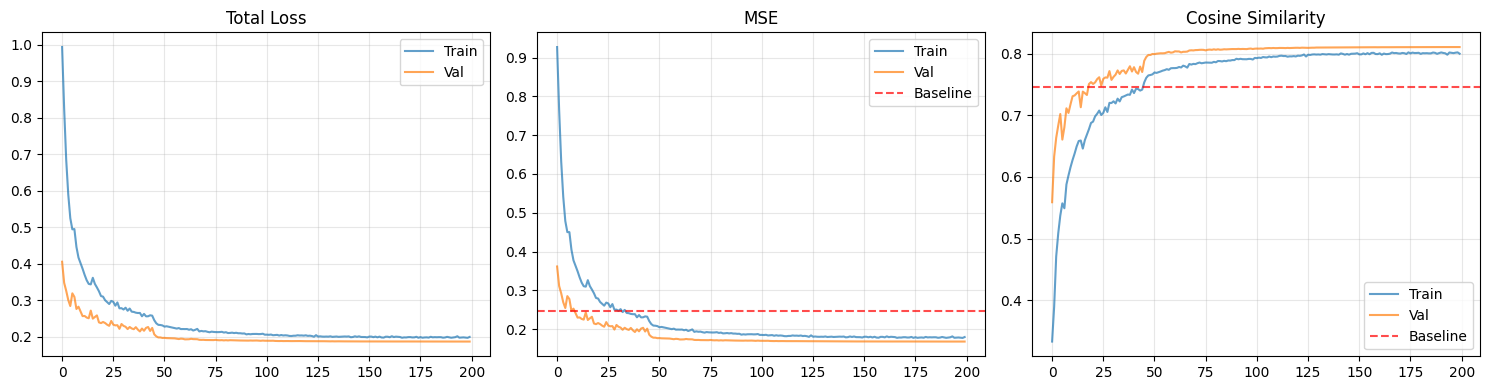

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['train_total'], label='Train', alpha=0.7)
axes[0].plot(history['val_total'], label='Val', alpha=0.7)
axes[0].set_title('Total Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_mse'], label='Train', alpha=0.7)
axes[1].plot(history['val_mse'], label='Val', alpha=0.7)
if baseline:
    axes[1].axhline(baseline['mse'], color='r', linestyle='--', label='Baseline', alpha=0.7)
axes[1].set_title('MSE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(history['train_cosine_sim'], label='Train', alpha=0.7)
axes[2].plot(history['val_cosine_sim'], label='Val', alpha=0.7)
if baseline:
    axes[2].axhline(baseline['cosine_sim'], color='r', linestyle='--', label='Baseline', alpha=0.7)
axes[2].set_title('Cosine Similarity')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(cfg.output_dir / 'curves.png', dpi=150)
plt.show()

In [ ]:
# Load best checkpoint
checkpoint = torch.load(cfg.output_dir / "best_encoder.pt")
mimi.encoder.load_state_dict(checkpoint['encoder_state_dict'])
print(f"Loaded checkpoint from epoch {checkpoint['epoch']} (val_loss: {checkpoint['val_loss']:.6f})")

final = validate(val_dataset)

print("\n=== Final Results ===")
print(f"Our Model - MSE: {final['mse']:.6f}, Cosine: {final['cosine_sim']:.4f}")

if baseline:
    print(f"Baseline  - MSE: {baseline['mse']:.6f}, Cosine: {baseline['cosine_sim']:.4f}")
    mse_imp = (baseline['mse'] - final['mse']) / baseline['mse'] * 100
    cos_imp = (final['cosine_sim'] - baseline['cosine_sim']) / baseline['cosine_sim'] * 100
    print(f"Improvement - MSE: {mse_imp:+.2f}%, Cosine: {cos_imp:+.2f}%")
    
print(f"\nSaved to: {cfg.output_dir / 'best_encoder.pt'}")

# generate embeddings

In [ ]:
from safetensors.torch import save_file

def process_audio(audio_path, mimi, adapter):
    """Load audio file, convert to embedding."""
    # Load audio (supports WAV, MP3, etc via torchaudio)
    waveform, sr = torchaudio.load(audio_path)

    # Resample to 24kHz if needed
    if sr != mimi.sample_rate:
        waveform = torchaudio.transforms.Resample(sr, mimi.sample_rate)(waveform)

    # Take first max_duration seconds, convert to mono
    max_samples = int(mimi.sample_rate * cfg.max_duration)
    wav = waveform#[:, :max_samples]
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)

    # Pad if shorter than max_duration
    if wav.shape[-1] < max_samples:
        wav = torch.nn.functional.pad(wav, (0, max_samples - wav.shape[-1]))

    # Add batch dimension
    wav = wav.unsqueeze(0).to(DEVICE)

    # Generate embedding
    with torch.no_grad():
        emb = mimi.encode_to_latent(wav, quantize=False)
        emb = adapter(emb)

    return emb


# Find all audio files (wav, mp3, flac, etc)
audio_files = list(Path("/samples").glob(f"*.mp3"))

print(f"Found {len(audio_files)} audio files")
# Process each file
for audio_file in tqdm(audio_files, desc="Processing"):
    try:
        emb = process_audio(audio_file, mimi, adapter)

        # Save embedding as safetensors (Kyutai TTS format)
        ext = ".1e68beda@240.safetensors"
        out_file = Path("/voices") / ("uncut_" + audio_file.name + ext)

        tensors = {"speaker_wavs": emb.cpu().contiguous()}
        metadata = {"epoch": "240", "sig": "1e68beda"}
        save_file(tensors, out_file, metadata)

        tqdm.write(f"✓ {audio_file.name} → {out_file.name}")

    except Exception as e:
        tqdm.write(f"✗ {audio_file.name}: {e}")
